In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

print('TF version:', tf.__version__)
print('TFP version:', tfp.__version__)

TF version: 2.4.1
TFP version: 0.12.1


In [ ]:
# mount drive

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# load numpy array from csv file
from numpy import loadtxt
# load array
X_val = loadtxt('/gdrive/My Drive/x_val_deterministic_regression.csv', delimiter=',')
X_val[1,:]

array([ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  1.        ,  1.        ,
        0.        ,  1.        , -0.60046446, -0.73944424, -0.42612414,
        0.80879859, -0.39224086, -0.31303647, -0.26571504, -0.24252588,
       -0.23272301, -0.23578721, -0.64566378,  1.46121236, -0.50705761,
       -0.33771497, -0.157763  , -0.0453126 , -0.03019119, -0.26375666,
        0.86355668])

In [ ]:
# load numpy array from csv file

y_val = loadtxt('/gdrive/My Drive/y_val_deterministic_regression.csv', delimiter=',')
y_val[:2]

array([3.66356165, 4.38202663])

In [ ]:
X_train = loadtxt('/gdrive/My Drive/x_train_deterministic_regression.csv', delimiter=',')
y_train = loadtxt('/gdrive/My Drive/y_train_deterministic_regression.csv', delimiter=',')

In [ ]:
import pickle

filename = '/gdrive/My Drive/deterministic_regression_model.sav'
deterministic_regression = pickle.load(open(filename, 'rb'))

In [ ]:
X_val.shape

(3294, 36)

In [ ]:
# This will be more easily visualized in 2d so let's pick a feature
# from X_train that has a fairly strong correlation with monthly
# average spend. From the numerical variables we knew yearly income
# had a strong correlation to monthly average spend and it also
# survived feature selection

x_train_one = X_train[:,-1] 
x_train_one 

array([ 0.09526313,  1.04291595, -0.82663665, ..., -0.46008546,
        0.65196325,  0.70443053])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


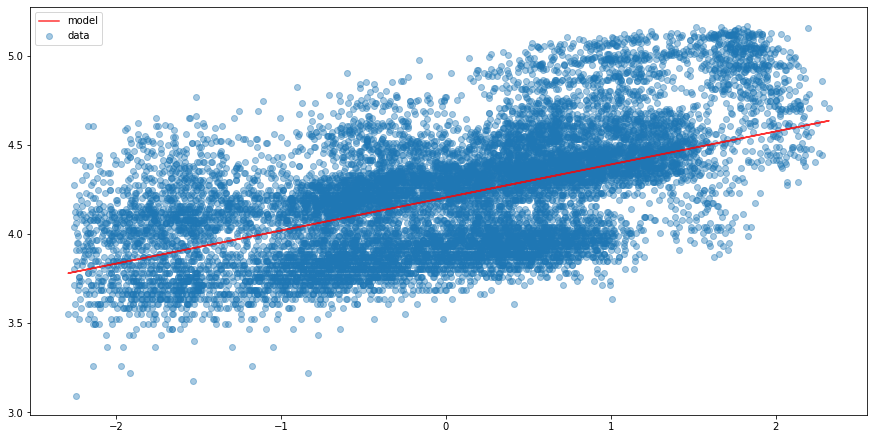

In [ ]:

# Create and train deterministic linear model using mean squared error loss
# this is equivalent to our sci-kit learn model
# we will use one predictor variable in order to visualize in two dimensions

model = Sequential([
    Dense(units=1, input_shape=(1,))
])
model.compile(loss=MeanSquaredError(), optimizer=RMSprop(learning_rate=0.005))
model.summary()
model.fit(x_train_one, y_train, epochs=200, verbose=False)

# Plot the data and model
plt.figure(figsize=(15, 7.5)) 
plt.scatter(x_train_one, y_train, alpha=0.4, label='data')
plt.plot(x_train_one, model.predict(x_train_one), color='red', alpha=0.8, label='model')
plt.legend()
plt.show()

In [ ]:
# Create negative log likelihood loss function

def nll(y_true, y_pred):
  """negative log likelihood"""
  return -y_pred.log_prob(y_true)

In [ ]:
# Create probabilistic regression: normal distribution with fixed variance

model = Sequential([
    Dense(input_shape=(1,), units=8, activation='sigmoid'),
    Dense(tfpl.IndependentNormal.params_size(event_shape=1)),
    tfpl.IndependentNormal(event_shape=1)
])
model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.01))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 16        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 18        
_________________________________________________________________
independent_normal (Independ multiple                  0         
Total params: 34
Trainable params: 34
Non-trainable params: 0
_________________________________________________________________


In [ ]:

# callback to stop training if no further improvement
def get_early_stopping():
    """
    This function should return an EarlyStopping callback that stops training when
    the loss has not improved in the last 5 epochs.
    
    """
    return tf.keras.callbacks.EarlyStopping(monitor='loss', mode="min", patience=5)

In [ ]:
# Train model

#x_train_one = x_train_one[:, np.newaxis]


model.fit(x_train_one, y_train, epochs=200, verbose=False, callbacks=[get_early_stopping()])


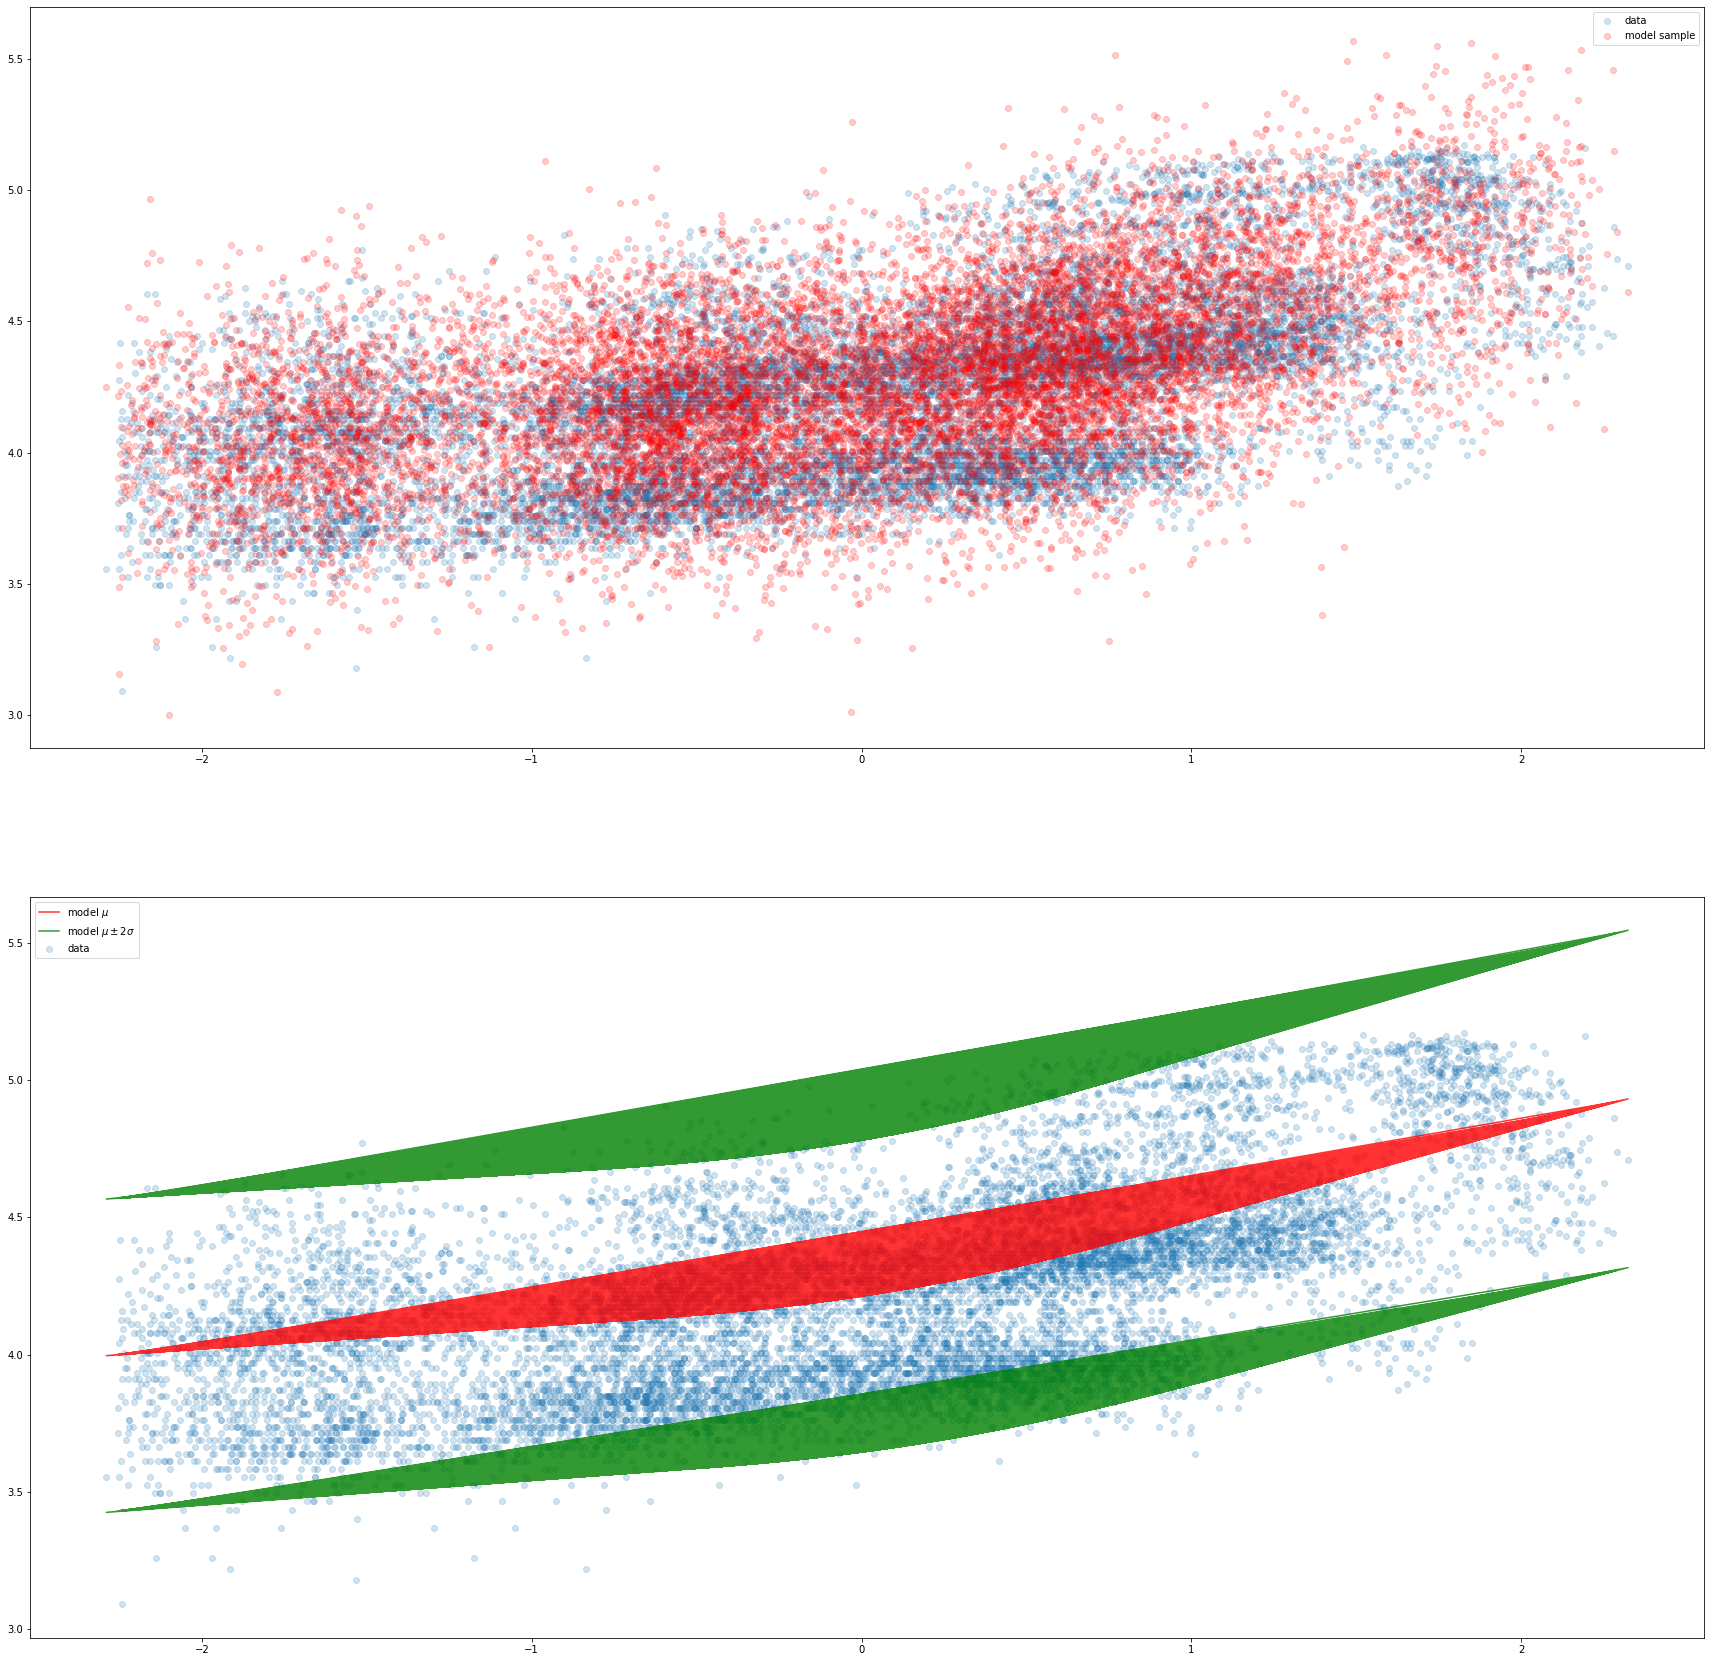

In [ ]:


y_model = model(x_train_one[:, np.newaxis])
y_sample = y_model.sample()
y_hat = y_model.mean()
y_sd = y_model.stddev()
y_hat_m2sd = y_hat - 2 * y_sd
y_hat_p2sd = y_hat + 2 * y_sd

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 30))
ax1.scatter(x_train_one, y_train, alpha=0.2, label='data')
ax1.scatter(x_train_one, y_sample, alpha=0.2, color='red', label='model sample')
ax1.legend()
ax2.scatter(x_train_one, y_train, alpha=0.2, label='data')
ax2.plot(x_train_one, y_hat, color='red', alpha=0.8, label='model $\mu$')
ax2.plot(x_train_one, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
ax2.plot(x_train_one, y_hat_p2sd, color='green', alpha=0.8)
ax2.legend()
plt.show()

In [ ]:
# Create probabilistic regression: normal distribution with fixed variance
# All features

model2 = Sequential([
    Dense(input_shape=(36,), units=8, activation='sigmoid'),
    Dense(tfpl.IndependentNormal.params_size(event_shape=1)),
    tfpl.IndependentNormal(event_shape=1)
])
model2.compile(loss=nll, optimizer=RMSprop(learning_rate=0.01))
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 8)                 296       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 18        
_________________________________________________________________
independent_normal_1 (Indepe multiple                  0         
Total params: 314
Trainable params: 314
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2.fit(X_train, y_train.flatten(), epochs=200, verbose=False, callbacks=[get_early_stopping()])

In [ ]:
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))

    ax1 = sns.kdeplot(RedFunction, color="r", label=RedName)
    ax2 = sns.kdeplot(BlueFunction, color="b", label=BlueName, ax=ax1)

    plt.title(Title)
    plt.xlabel('Features')
    plt.ylabel('AveMonthPayment')
    plt.legend(labels=[RedName, BlueName])

    plt.show()
    plt.close()

In [ ]:
import pandas as pd


In [ ]:
y_train.shape

(13177,)

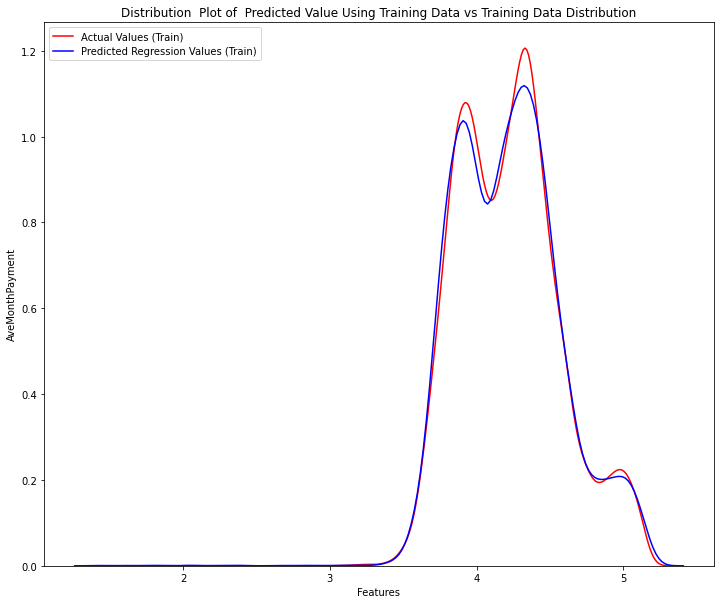

In [ ]:
Title = 'Distribution  Plot of  Predicted Value Using Training Data vs Training Data Distribution'
DistributionPlot(y_train, pd.Series(model2(X_train).sample().numpy().flatten()).to_frame('Predictions').values.flatten() , "Actual Values (Train)", "Predicted Regression Values (Train)", Title)

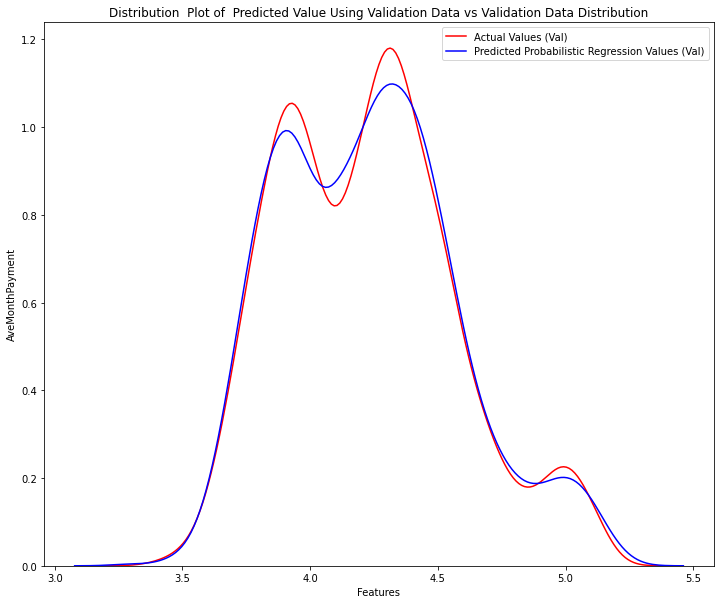

In [ ]:
Title = 'Distribution  Plot of  Predicted Value Using Validation Data vs Validation Data Distribution'
DistributionPlot(y_val, pd.Series(model2(X_val).sample().numpy().flatten()).to_frame('ValPredictions').values.flatten(), "Actual Values (Val)", "Predicted Probabilistic Regression Values (Val)", Title)

In [ ]:
y_model = model2(X_val)
y_sample = y_model.sample()
y_hat = y_model.mean()
y_sd = y_model.stddev()
y_hat_m2sd = y_hat - 2 * y_sd
y_hat_p2sd = y_hat + 2 * y_sd

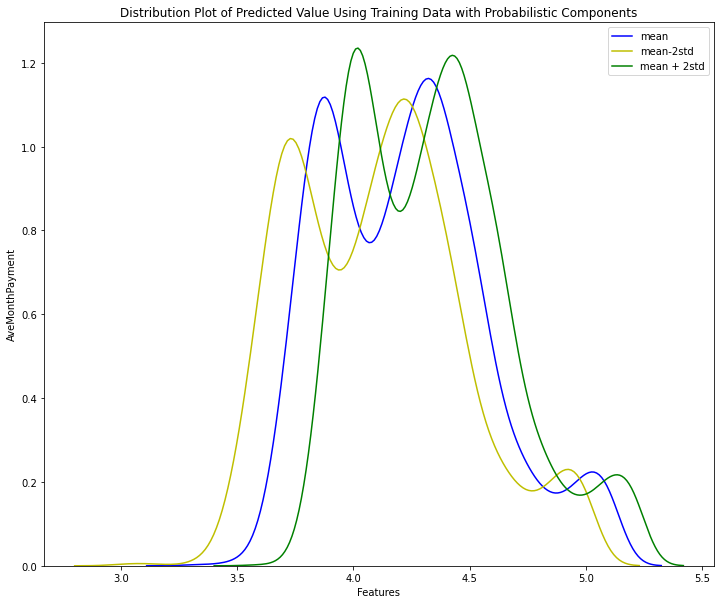

In [ ]:
Title = 'Distribution Plot of Predicted Value Using Training Data with Probabilistic Components'


width = 12
height = 10
plt.figure(figsize=(width, height))

ax1 = sns.kdeplot(y_hat.numpy().flatten(), label='mean', color="b")
ax2 = sns.kdeplot(y_hat_m2sd.numpy().flatten() , label = 'mean - 2std', color="y",  ax=ax1)
ax3 = sns.kdeplot(y_hat_p2sd.numpy().flatten() , label = 'mean + 2std', color="g", ax=ax2)

plt.title(Title)
plt.xlabel('Features')
plt.ylabel('AveMonthPayment')
plt.legend(labels=['mean','mean-2std', 'mean + 2std'])

plt.show()
plt.close()


In [ ]:
import sklearn.metrics as sklm
import math
import scipy.stats as ss

Mean Square Error      = 0.006636618681306781
Root Mean Square Error = 0.0814654447069847
Mean Absolute Error    = 0.06345527422237479
Median Absolute Error  = 0.05103612342618424
R^2                    = 0.9444224391087421
Adjusted R^2           = 0.9385849301963382


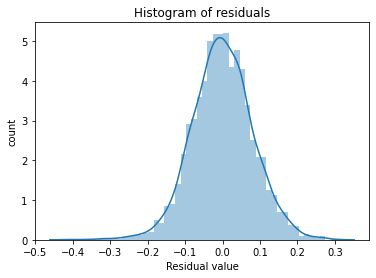

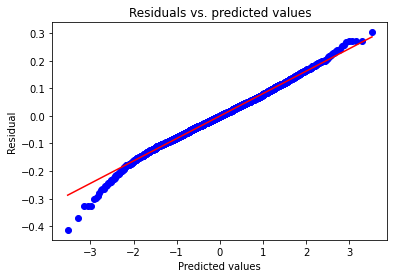

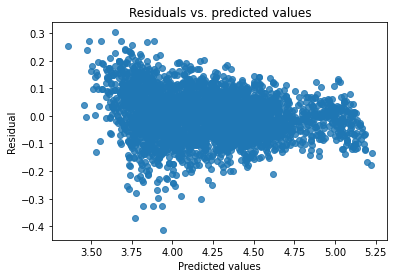

In [ ]:
def print_metrics(y_true, y_predicted, n_parameters):
    ## First compute R^2 and the adjusted R^2
    r2 = sklm.r2_score(y_true, y_predicted)
    r2_adj = r2 - (n_parameters - 1)/(y_true.shape[0] - n_parameters) * (1 - r2)
    
    ## Print the usual metrics and the R^2 values
    print('Mean Square Error      = ' + str(sklm.mean_squared_error(y_true, y_predicted)))
    print('Root Mean Square Error = ' + str(math.sqrt(sklm.mean_squared_error(y_true, y_predicted))))
    print('Mean Absolute Error    = ' + str(sklm.mean_absolute_error(y_true, y_predicted)))
    print('Median Absolute Error  = ' + str(sklm.median_absolute_error(y_true, y_predicted)))
    print('R^2                    = ' + str(r2))
    print('Adjusted R^2           = ' + str(r2_adj))
    
    
def resid_plot(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    sns.regplot(y_score, resids, fit_reg=False)
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')
    plt.show()

def hist_resids(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    sns.distplot(resids)
    plt.title('Histogram of residuals')
    plt.xlabel('Residual value')
    plt.ylabel('count')
    plt.show()
    
def resid_qq(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test, y_score)
    ## now make the residual plots
    ss.probplot(resids.flatten(), plot = plt)
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')
    plt.show()
    
# Predict with Validation set

y_score_val = y_sample.numpy().flatten()
print_metrics(y_val, y_score_val, 314) 
hist_resids(y_val, y_score_val)  
resid_qq(y_val, y_score_val) 
resid_plot(y_val, y_score_val) 

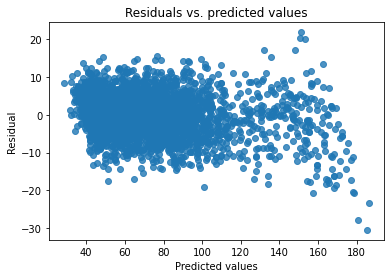

In [ ]:
# Actual residuals - recall that we took the log
# so we will transform it back 

y_score_val_untransform = np.exp(y_score_val)
y_val_untransform = np.exp(y_val)
resid_plot(y_val_untransform, y_score_val_untransform)

In [ ]:
# Define the prior weight distribution -- all N(0, 1) -- and not trainable

def prior(kernel_size, bias_size, dtype=None):
  n = kernel_size + bias_size
  prior_model = Sequential([
                tfpl.DistributionLambda(
                    lambda t : tfd.MultivariateNormalDiag(loc=tf.zeros(n), scale_diag=tf.ones(n))
                )
  ])

  return prior_model

In [ ]:
# Define variational posterior weight distribution -- multivariate Gaussian

def posterior(kernel_size, bias_size, dtype=None):
  n = kernel_size + bias_size
  posterior_model=Sequential([
            tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n), dtype=dtype),
            tfpl.MultivariateNormalTriL(n)
  ])

  return posterior_model

In [ ]:
# Create probabilistic regression with one hidden layer, weight uncertainty

model3 = Sequential([
    tfpl.DenseVariational(units=8,
                          input_shape=(1,),
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/X_train.shape[0],
                          activation='sigmoid'),
    tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/X_train.shape[0]),
    tfpl.IndependentNormal(1)
])



model3.compile(loss=nll, optimizer=RMSprop(learning_rate=0.005))
model3.summary()

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational (DenseVari (None, 8)                 152       
_________________________________________________________________
dense_variational_1 (DenseVa (None, 2)                 189       
_________________________________________________________________
independent_normal_2 (Indepe multiple                  0         
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train the model



model3.fit(x_train_one, y_train, epochs=1000, verbose=False)
model3.evaluate(x_train_one, y_train)

412/412 [==============================] - 1s 2ms/step - loss: 0.1578


0.15784557163715363

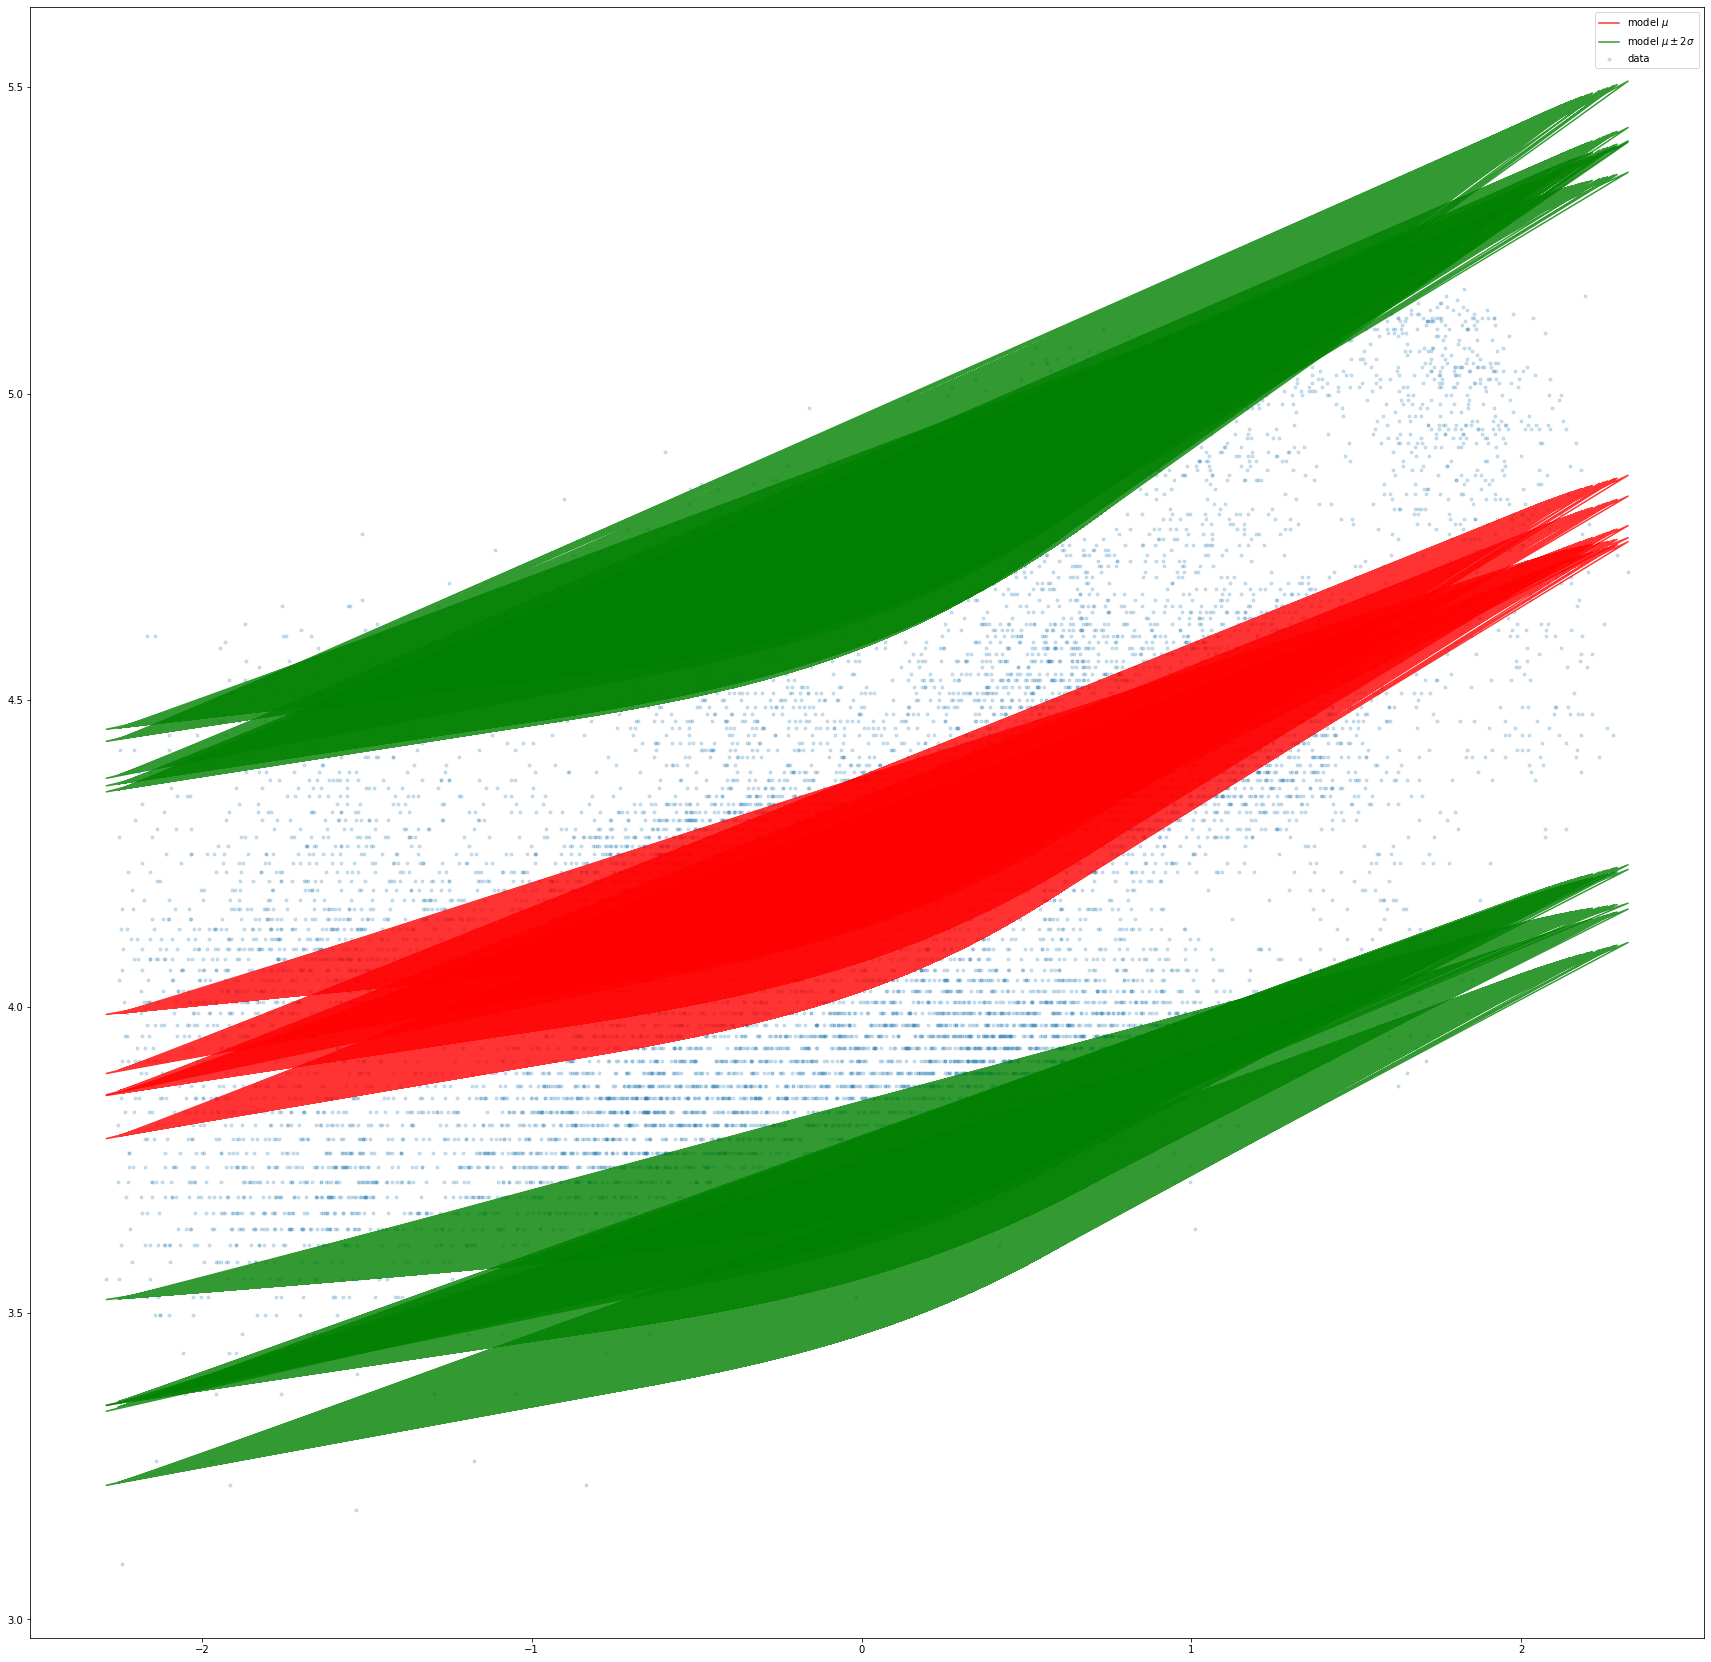

In [ ]:
# Plot an ensemble of trained probabilistic regressions
plt.figure(figsize=(30,30))
plt.scatter(x_train_one, y_train, marker='.', alpha=0.2, label='data')
for _ in range(5):
    y_model = model3(x_train_one[:, np.newaxis])
    y_hat = y_model.mean()
    y_hat_m2sd = y_hat - 2 * y_model.stddev()
    y_hat_p2sd = y_hat + 2 * y_model.stddev()
    if _ == 0:
        plt.plot(x_train_one, y_hat, color='red', alpha=0.8, label='model $\mu$')
        plt.plot(x_train_one, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
        plt.plot(x_train_one, y_hat_p2sd, color='green', alpha=0.8)
    else:
        plt.plot(x_train_one, y_hat, color='red', alpha=0.8)
        plt.plot(x_train_one, y_hat_m2sd, color='green', alpha=0.8)
        plt.plot(x_train_one, y_hat_p2sd, color='green', alpha=0.8)        
plt.legend()

plt.show()
